# Imports

In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization import plot_histogram
from qiskit.extensions.unitary import unitary
from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile, assemble
from qiskit.providers.aer import QasmSimulator
S_simulator = Aer.backends(name = 'statevector_simulator')[0]
M_simulator = Aer.backends(name = 'qasm_simulator')[0]

backend = QasmSimulator(configuration = {'method' : 'density_matrix'})
M_simulator = backend


import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import misc
import cv2
import os
import time
import sys
from datetime import datetime
import sklearn.metrics
import itertools
import io

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

%matplotlib inline

# Auxiliar Functions

In [2]:
def draw(qc):
    return circuit_drawer(qc, scale = 1, cregbundle  = False, output = 'mpl', fold = 24, initial_state = True)
def hist(readout):
    return plot_histogram(readout)

In [3]:
def convolution(FOCUS, FILTER, shots = 8192):
    '''
    FOCUS = [[F00, F01],
             [F10, F11]]
    FILTER = [[FI00, FI01],
              [FI10, FI11]]
    '''
    q = QuantumRegister(4, name = 'q_r')
    a = QuantumRegister(1, name = 'a_r')
    c = ClassicalRegister(1, name = 'c_r')
    qc = QuantumCircuit(q, a, c, name = 'q_circ')

    qc.h(q)

    qc.u3(FOCUS[0, 0] * FILTER[0, 0], FOCUS[0, 0] * FILTER[0, 1], FOCUS[0, 0] * FILTER[1, 0], q[0])

    qc.u3(FOCUS[0, 1] * FILTER[0, 0], FOCUS[0, 1] * FILTER[0, 1], FOCUS[0, 1] * FILTER[1, 0], q[1])

    qc.u3(FOCUS[1, 0] * FILTER[0, 0], FOCUS[1, 0] * FILTER[0, 1], FOCUS[1, 0] * FILTER[1, 0], q[2])

    qc.u3(FOCUS[1, 1] * FILTER[0, 0], FOCUS[1, 1] * FILTER[0, 1], FOCUS[1, 1] * FILTER[1, 0], q[3])
    
    qc.h(q)

    qc.mct(q, a, None, mode = 'noancilla')

    qc.measure(a[0], c)

    #transpiled_circuit = transpile(qc, M_simulator, optimization_level = 1)
    #job = M_simulator.run(assemble(transpiled_circuit, shots = shots))
    job = execute(qc, M_simulator, shots = shots, optimization_level = 1)
    results = job.result()

    readout = results.get_counts()
    convolution = (readout.get('1', 0) / shots) * FILTER[1, 1]
    return convolution, readout, qc

In [4]:
def Qonv2D(filters = 1, kernel_size = (2, 2), stride = (1, 1), image = None):
    np.random.seed(465)
    N_FILTERS = filters
    KERNEL = kernel_size
    STRIDE = stride
    FILTERS = np.random.random(size = (N_FILTERS, KERNEL[0], KERNEL[1])) * np.pi
    CONV_SHAPE = ((image.shape[0] - KERNEL[0]) // STRIDE[0] + 1, (image.shape[0] - KERNEL[0]) // STRIDE[1] + 1, N_FILTERS)
    '''
    CONV_SHAPE = ((image.shape[0] - KERNEL[0]) // STRIDE[0] + 1, (image.shape[0] - KERNEL[0]) // STRIDE[1] + 1)
    CONV_OUTPUT = [] # shape = (Filters, CONV_IMAGE.shape)
    for FILTER in FILTERS:
        CONV_IMAGE = [] # shape = (((image.shape[0] - KERNEL[0]) // STRIDE[0] + 1, (image.shape[0] - KERNEL[0]) // STRIDE[1] + 1))
        for row in range(0, image.shape[0] - KERNEL[0] + 1, STRIDE[0]):
            for col in range(0, image.shape[1] - KERNEL[1] + 1, STRIDE[1]):
                focus = image[row : row + KERNEL[0], col : col + KERNEL[1]]
                convol = convolution(focus, FILTER, shots = 100)
                CONV_IMAGE.append(convol[0])
        CONV_OUTPUT.append(np.array(CONV_IMAGE).reshape(CONV_SHAPE))'''
    CONV_IMAGE = [[] for _ in range(N_FILTERS)] # shape = (((image.shape[0] - KERNEL[0]) // STRIDE + 1, (image.shape[0] - KERNEL[0]) // STRIDE + 1))
    for row in range(0, image.shape[0] - KERNEL[0] + 1, STRIDE[0]):
        for col in range(0, image.shape[1] - KERNEL[1] + 1, STRIDE[1]):
            for index, FILTER in enumerate(FILTERS):
                focus = image[row : row + KERNEL[0], col : col + KERNEL[1]]
                convol = convolution(focus, FILTER, shots = 100)
                CONV_IMAGE[index].append(convol[0])
    CONV_OUTPUT = np.stack(CONV_IMAGE, axis = -1)
    CONV_OUTPUT = CONV_OUTPUT.reshape(CONV_SHAPE)
    return CONV_OUTPUT

In [5]:
def qonv2D(FILTERS = None, kernel_size = (2, 2), stride = (1, 1), image = None):
    KERNEL = kernel_size
    STRIDE = stride
    N_FILTERS = FILTERS.shape[0]
    CONV_SHAPE = ((image.shape[0] - KERNEL[0]) // STRIDE[0] + 1, (image.shape[0] - KERNEL[0]) // STRIDE[1] + 1, N_FILTERS)
    
    CONV_IMAGE = [[] for _ in range(N_FILTERS)]
    for row in range(0, image.shape[0] - KERNEL[0] + 1, STRIDE[0]):
        for col in range(0, image.shape[1] - KERNEL[1] + 1, STRIDE[1]):
            for index, FILTER in enumerate(FILTERS):
                focus = image[row : row + KERNEL[0], col : col + KERNEL[1]]
                convol = convolution(focus, FILTER, shots = 100)
                CONV_IMAGE[index].append(convol[0])
    CONV_OUTPUT = np.stack(CONV_IMAGE, axis = -1)
    CONV_OUTPUT = CONV_OUTPUT.reshape(CONV_SHAPE)
    return CONV_OUTPUT

In [6]:
def conv_sample(c_images, q_images, samples = 4, channels = 4):
    n_samples = 4
    n_channels = 4
    fig, axes = plt.subplots(1 + channels, samples, figsize=(10, 10))
    for k in range(samples):
        axes[0, 0].set_ylabel("Input image")
        if k != 0:
            axes[0, k].yaxis.set_visible(False)
        axes[0, k].imshow(c_images[k, :, :, 0], cmap="gray")

        # Plot all output channels
        for c in range(channels):
            axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
            if k != 0:
                axes[c, k].yaxis.set_visible(False)
            axes[c + 1, k].imshow(q_images[k, :, :, c], cmap="gray")

    plt.tight_layout()
    return plt.show()

In [7]:
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def clog_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = classical_model.predict(X_test)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(np.argmax(Y_test, axis=1), test_pred)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names = list(range(10)))
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with classical_file_writer_cm.as_default():
        tf.summary.image("Classic Confusion Matrix", cm_image, step=epoch)
        
def qlog_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = quantum_model.predict(Q_test_images)
    test_pred = np.argmax(test_pred_raw, axis = 1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(np.argmax(Y_test, axis=1), test_pred)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names = list(range(10)))
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with quantum_file_writer_cm.as_default():
        tf.summary.image("Quantum Confusion Matrix", cm_image, step=epoch)

# Hyperparameters and loading original MNIST Dataset

In [8]:
# Defining hyperparameters
EPOCH = 30
train_size = 1000
test_size = 200
BATCH_SIZE = 10

DATASET_PATH = os.path.sep.join([os.getcwd(), "Dataset"])
print(DATASET_PATH)

np.random.seed(100)
tf.random.set_seed(200)

C:\Users\jeff_\Dropbox\Jupyter Notebooks\Quantum\Qonvolution\Dataset


In [9]:
# Loading MNIST
((x_train, y_train), (x_test, y_test)) = mnist.load_data()

# Adding a channel dimension and scaling
x_train = np.expand_dims(x_train, axis = -1)
x_test = np.expand_dims(x_test, axis = -1)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# One-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Image Quantum Preprocessing

In [10]:
X_train = x_train[:train_size]
X_test = x_test[:test_size]
Y_train = y_train[:train_size]
Y_test = y_test[:test_size]

In [8]:
# Setting random filters
np.random.seed(1918)
FILTERS = np.random.random(size = (4, 2, 2)) * np.pi

In [9]:
FILTERS

array([[[0.59104061, 0.7498608 ],
        [2.92344813, 0.10024845]],

       [[1.31817723, 0.33983809],
        [2.21768245, 0.02631693]],

       [[2.39360192, 2.7985645 ],
        [0.02755075, 0.64261417]],

       [[2.84046874, 2.33452561],
        [0.07662386, 2.27291504]]])

### Quantum Pre-process

Run it if you want to generate Qonvolutions, otherwise load the .npy files with Qonvolutions already saved in.

In [21]:
Q_train_images = []

print("\n[INFO] Quantum processing of train images...")
preprocessStart = time.time()
for idx, img in enumerate(X_train):
    sys.stdout.write('\rProcess {:02d}% : {}{}'.format((idx * 100) // train_size, '=' * (idx // 2), '>'))
    Q_train_images.append(qonv2D(FILTERS = FILTERS, kernel_size = (2, 2), stride = (1, 1), image = img))
sys.stdout.flush()
preprocessEnd = time.time()
elapsed = (preprocessEnd - preprocessStart) / 60.0
sys.stdout.write('\rProcess {:02d}% : {}{} Processed {} train images in {:.4} minutes'.format(100, '=' * (idx // 2), '>', len(X_train), elapsed))
Q_train_images = np.asarray(Q_train_images)

Q_test_images = []
print("\n[INFO] Quantum processing of train images...")
preprocessStart = time.time()
for idx, img in enumerate(X_test):
    sys.stdout.write('\rProcess {:02d}% : {}{}'.format((idx * 100) // test_size, '=' * (idx // 2), '>'))
    Q_test_images.append(qonv2D(FILTERS = FILTERS, kernel_size = (2, 2), stride = (1, 1), image = img))
sys.stdout.flush()
preprocessEnd = time.time()
elapsed = (preprocessEnd - preprocessStart) / 60.0
sys.stdout.write('\rProcess {:02d}% : {}{} Processed {} train images in {:.4} minutes'.format(100, '=' * (idx // 2), '>', len(X_train), elapsed))
Q_test_images = np.asarray(Q_test_images)

# Save pre-processed images
np.save(DATASET_PATH + "Q_train_images.npy", Q_train_images)
np.save(DATASET_PATH + "Q_test_images.npy", Q_test_images)


[INFO] Quantum processing of train images...
Process 100% : ===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================> Processed 1000 train images in 156.9 minutes
[INFO] Quantum processing of train images...
Process 100% : ===================================================================================================> Processed 1000 train images in 30.66 minutes

### Loading Qonvoluted Pre-processed images

In [11]:
# Load pre-processed images
Q_train_images = np.load(os.path.sep.join([DATASET_PATH, "q_train_images.npy"]))
Q_test_images = np.load(os.path.sep.join([DATASET_PATH, "q_test_images.npy"]))

In [12]:
print(f'Qonvoluted training images shape (#Images, height, width, channels): {Q_train_images.shape}')
print(f'Qonvoluted testing images shape (#Images, height, width, channels): {Q_test_images.shape}')

Qonvoluted training images shape (#Images, height, width, channels): (1000, 27, 27, 4)
Qonvoluted testing images shape (#Images, height, width, channels): (200, 27, 27, 4)


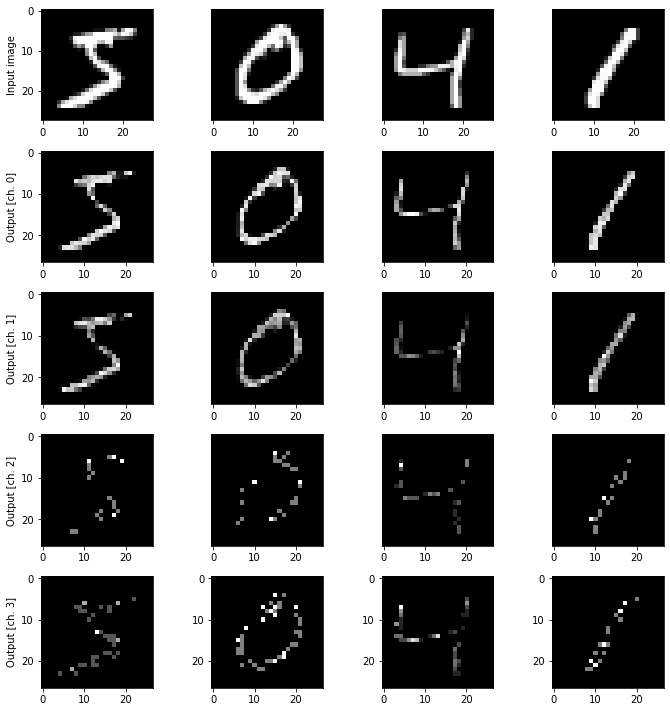

In [13]:
conv_sample(X_train, Q_train_images, samples = 4, channels = 4)

## Single convolution sample

In [27]:
CONV_OUTPUT = qonv2D(FILTERS, (2, 2), (1, 1), X_train[1])

In [28]:
CONV_OUTPUT.shape

(27, 27, 4)

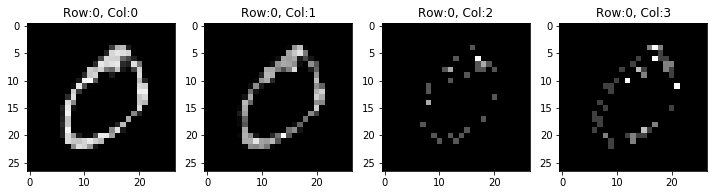

In [29]:
h, w = 10, 10        # for raster image
nrows, ncols = 1, 4  # array of sub-plots
figsize = [10, 12]     # figure size, inches

# prep (x,y) for extra plotting on selected sub-plots

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)

# plot simple raster image on each sub-plot
for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    axi.imshow(CONV_OUTPUT[:, :, i], cmap = 'gray')
    # get indices of row/column
    rowid = i // ncols
    colid = i % ncols
    # write row/col indices as axes' title for identification
    axi.set_title("Row:"+str(rowid)+", Col:"+str(colid))

# one can access the axes by ax[row_id][col_id]
# do additional plotting on ax[row_id][col_id] of your choice
#ax[0][2].plot(xs, 3*ys, color='red', linewidth=3)
#ax[4][3].plot(ys**2, xs, color='green', linewidth=3)

plt.tight_layout(True)
plt.show()

# Models Design

Models definition.
A classical and hybrid convnet models are defined, compiled and fit. History data is shown afterwards.

In the $hybrid$ model case, since the input are in essence the output of a convolution, the initial layers of the model
are an Identity -> Activation -> BatchNormalization -> MaxPooling2D. The subsequent layers are in the traditional way.

For the classical model a simple convnet is defined, imitating the structure of the hybrid model.

In [31]:
def HybridModel(width, height, depth, classes):
    input_shape = (height, width, depth)
    chanDim = -1
    
    model = Sequential(name = 'Quantum_model')
    model.add(Lambda(lambda x : x, output_shape = input_shape, input_shape = input_shape))
    #model.add(Conv2D(filters = 4, kernel_size = (2, 2), strides = (2, 2), input_shape = input_shape))
    model.add(Activation(tf.nn.relu))
    model.add(BatchNormalization(axis = chanDim))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(filters = 32, kernel_size = (3, 3)))
    model.add(Activation(tf.nn.relu))
    model.add(BatchNormalization(axis = chanDim))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same"))
    model.add(Activation(tf.nn.relu))
    model.add(BatchNormalization(axis = chanDim))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Flatten())
    #model.add(Dense(units = 10))
    #model.add(Activation(tf.nn.relu))
    #model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(units = classes))
    model.add(Activation(tf.nn.softmax))
    
    return model

def ClassicModel(width, height, depth, classes):
    input_shape = (height, width, depth)
    chanDim = -1
    
    model = Sequential(name = 'Classical_Convenet_model')
    model.add(Conv2D(filters = 4, kernel_size = (2, 2), strides = (1, 1), input_shape = input_shape))
    model.add(Activation(tf.nn.relu))
    model.add(BatchNormalization(axis = chanDim))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(filters = 32, kernel_size = (3, 3)))
    model.add(Activation(tf.nn.relu))
    model.add(BatchNormalization(axis = chanDim))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same"))
    model.add(Activation(tf.nn.relu))
    model.add(BatchNormalization(axis = chanDim))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Flatten())
    #model.add(Dense(units = 10))
    #model.add(Activation(tf.nn.relu))
    #model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(units = classes))
    model.add(Activation(tf.nn.softmax))
    
    return model

In [32]:
# Model recieves as parameters the shape of the Quantum convolution output size,
# which is ((image.shape[0] - KERNEL[0]) // STRIDE[0] + 1, (image.shape[0] - KERNEL[0]) // STRIDE[1] + 1, N_FILTERS)
# and a final parameters which is the number of classes in the dataset.
quantum_model = HybridModel(27, 27, 4, 10)

classical_model = ClassicModel(28, 28, 1, 10)

In [33]:
quantum_model.summary()

Model: "Quantum_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 27, 27, 4)         0         
_________________________________________________________________
activation (Activation)      (None, 27, 27, 4)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 4)         16        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 11, 11, 32)        1184      
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 32)      

In [34]:
classical_model.summary()

Model: "Classical_Convenet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 27, 27, 4)         20        
_________________________________________________________________
activation_4 (Activation)    (None, 27, 27, 4)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 27, 27, 4)         16        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        1184      
_________________________________________________________________
activation_5 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 11, 11

# Training models

* Definition of some file directories for Tensorboard log files.
* Also setting the optimizer and the loss.
* Setting the callbacks for Tensorboard and the Confusion Matrix.

In [35]:
classical_logdir = "logs/ctrain_data/" + datetime.now().strftime("%Y%m%d-%H%M%S")
quantum_logdir = "logs/qtrain_data/" + datetime.now().strftime("%Y%m%d-%H%M%S")


# Defining Keras object to optimze and callbacks
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits = False)
optimizer = tf.keras.optimizers.Adam()
TBCallback = tf.keras.callbacks.TensorBoard(
                                            log_dir = classical_logdir,
                                            histogram_freq = 0,
                                            write_graph = True,
                                            write_images = True,
                                            update_freq = 'epoch',
                                            profile_batch = (2, 10))
CTBCallback = tf.keras.callbacks.TensorBoard(
                                            log_dir = quantum_logdir,
                                            histogram_freq = 0,
                                            write_graph = True,
                                            write_images = True,
                                            update_freq = 'epoch',
                                            profile_batch = (2, 10))


# Define the per-epoch callback.
classical_cm_callback = keras.callbacks.LambdaCallback(on_epoch_end = clog_confusion_matrix)
quantum_cm_callback = keras.callbacks.LambdaCallback(on_epoch_end = qlog_confusion_matrix)

* Setting the file writers for the Tensorboard files
* Setting the file writers for the Confusion Matrix

In [36]:
classical_file_writer = tf.summary.create_file_writer(classical_logdir)

quantum_file_writer = tf.summary.create_file_writer(quantum_logdir)

classical_file_writer_cm = tf.summary.create_file_writer(classical_logdir + '/cm')

quantum_file_writer_cm = tf.summary.create_file_writer(quantum_logdir + '/cm')

Saving some quantum and classical training samples for Tensorboard visualization.

In [37]:
classical_samples = 25
quantum_samples = 25
with classical_file_writer.as_default():
  # Don't forget to reshape.
  images = np.reshape(X_train[0:classical_samples], (-1, 28, 28, 1))
  tf.summary.image(f"{classical_samples} classical training data examples", images, max_outputs=25, step=0)

with quantum_file_writer.as_default():
  # Don't forget to reshape.
  images = Q_train_images[0:quantum_samples,...]
  tf.summary.image(f"{quantum_samples} quantum training data examples", images, max_outputs=25, step=0)

Compiling models

In [45]:
quantum_model.compile(
            optimizer = optimizer,
            loss = loss_object,
            metrics = ['acc'])
classical_model.compile(
                        optimizer = optimizer,
                        loss = loss_object,
                        metrics = ['acc'])

Fitting quantum model

In [46]:
quantum_history = quantum_model.fit(Q_train_images, Y_train,
                    validation_data = (Q_test_images, Y_test),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCH,
                    verbose = 1,
                    callbacks = [TBCallback, quantum_cm_callback])

Epoch 1/30
100/100 [==============================] - 1s 12ms/step - loss: 0.0188 - acc: 0.9940 - val_loss: 0.3935 - val_acc: 0.8900
Epoch 2/30
100/100 [==============================] - 1s 12ms/step - loss: 0.0148 - acc: 0.9950 - val_loss: 0.3822 - val_acc: 0.9000
Epoch 3/30
100/100 [==============================] - 1s 10ms/step - loss: 0.0159 - acc: 0.9950 - val_loss: 0.3679 - val_acc: 0.9200
Epoch 4/30
100/100 [==============================] - 1s 10ms/step - loss: 0.0183 - acc: 0.9950 - val_loss: 0.3965 - val_acc: 0.9150
Epoch 5/30
100/100 [==============================] - 1s 10ms/step - loss: 0.0114 - acc: 0.9960 - val_loss: 0.4181 - val_acc: 0.8950
Epoch 6/30
100/100 [==============================] - 1s 10ms/step - loss: 0.0149 - acc: 0.9950 - val_loss: 0.3903 - val_acc: 0.8750
Epoch 7/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0113 - acc: 0.9960 - val_loss: 0.3805 - val_acc: 0.9050
Epoch 8/30
100/100 [==============================] - 1s 10ms/step - 

Fitting classical model

In [48]:
classical_history = classical_model.fit(X_train, Y_train,
                    validation_data = (X_test, Y_test),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCH,
                    verbose = 1,
                    callbacks = [CTBCallback, classical_cm_callback])

Epoch 1/30
100/100 [==============================] - 2s 17ms/step - loss: 0.0090 - acc: 0.9980 - val_loss: 0.0991 - val_acc: 0.9650
Epoch 2/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0099 - acc: 0.9960 - val_loss: 0.0695 - val_acc: 0.9600
Epoch 3/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0725 - val_acc: 0.9600
Epoch 4/30
100/100 [==============================] - 1s 12ms/step - loss: 0.0142 - acc: 0.9960 - val_loss: 0.0837 - val_acc: 0.9600
Epoch 5/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0120 - acc: 0.9970 - val_loss: 0.1055 - val_acc: 0.9600
Epoch 6/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0108 - acc: 0.9970 - val_loss: 0.0867 - val_acc: 0.9600
Epoch 7/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0086 - acc: 0.9980 - val_loss: 0.1075 - val_acc: 0.9500
Epoch 8/30
100/100 [==============================] - 1s 11ms/step - 

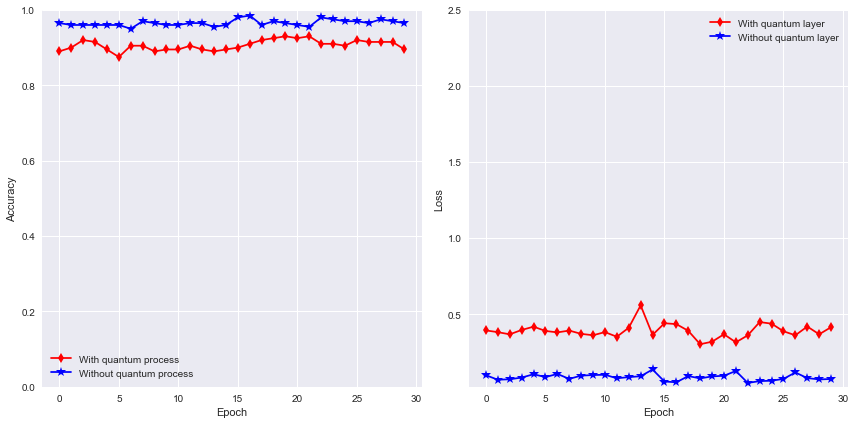

In [49]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(quantum_history.history["val_acc"], color = 'r', marker = 'd', label="With quantum process")
ax1.plot(classical_history.history["val_acc"], color = 'b', marker = '*', markersize = 10, label="Without quantum process")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(quantum_history.history["val_loss"], color = 'r', marker = 'd', label="With quantum layer")
ax2.plot(classical_history.history["val_loss"], color = 'b', marker = '*', markersize = 10, label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()